In [10]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

from tensorflow.keras import initializers, Model
from tensorflow.keras.layers import Dense, Layer, Conv2DTranspose, MaxPooling2D, Conv2D

import numpy as np
#import matplotlib.pyplot as plt

import random
from tqdm import tqdm
import time 

# Whats open: #
1. ''' ADD PROPER DATA & Accuracy '''
2. Problem with input shape / Network architecture
2. Plotting of bottleneck

In [11]:
# Hyperparameters
VERBOSE = True
SHUFFLE_SIZE = 1000
BATCH_SIZE = 1
PREFETCH_SIZE = 128
BUFFER_SIZE = 256

# Data

In [12]:
train_ds, test_ds = tfds.load('mnist', split=['train','test'], as_supervised=True)

In [13]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

### Show data

In [14]:
def add_noise(images, noise_factor = 0.1, noise_func = "normal"):
    if noise_func == "gaussian":
        sample_noise = keras.layers.GaussianNoise(noise_factor, dtype=tf.float32)
        noisy = sample_noise(images, training = True)
    elif noise_func == "normal":
        noisy = images + noise_factor * tf.random.normal(shape = images.shape)
        noisy = tf.clip_by_value(noisy, clip_value_min = 0., clip_value_max = 1.)
    return noisy

In [15]:
@tf.autograph.experimental.do_not_convert
def preprocess(data, noise_factor = 0.2, prepare = True):
    # Cast Image pixel values as floats
    data = data.map(lambda img, target: (tf.cast(img, tf.float32), target))
    # Normalize pixel values
    data = data.map(lambda img, target: ((img/255), target))
    # Add noise to the data
    data = data.map(lambda img, target: (add_noise(img, noise_factor = noise_factor), target))
    # Apply OneHot to picture labels
    data = data.map(lambda img, target: (img, tf.one_hot(target, 10)))
    # Shuffle, batch and prefetch
    if prepare: data = data.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE).prefetch(PREFETCH_SIZE)
    return data
    

In [16]:
train_ds_image = preprocess(train_ds, noise_factor = 0.2,prepare = False)
train_ds_noisy = preprocess(train_ds)
test_ds_noisy = preprocess(test_ds)

  #for image, label in train_ds_image.take(1):
#   plt.imshow(image)

# Model

### Convolutional Autoencoder

In [25]:
class Encoder(Layer):
  def __init__(self):
    super(Encoder, self).__init__()
    self.conv_1 = Conv2D(32, (3, 3), activation="relu", padding="same")
    self.pool_1 = MaxPooling2D((2, 2), padding="same")
    self.conv_2 = Conv2D(32, (3, 3), activation="relu", padding="same")
    self.pool_2 = MaxPooling2D((2, 2), padding="same")
    # In question
    #self.dense = Dense(7, activation = "relu")

  def call(self, input):
    x = self.conv_1(input)
    x = self.pool_1(x)
    x = self.conv_2(x)
    x = self.pool_1(x)
    #x = self.dense(x)

    return (x)



In [26]:
class Decoder(Layer):
  def __init__(self):
    super(Decoder, self).__init__()
    # In Question
    #self.dense = Dense(7, activation = "relu")
    self.transp_1 = Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")
    self.transp_2 = Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")
    self.conv_1 = Conv2D(1, (3, 3), activation="sigmoid", padding="same")

  def call(self, input):
    #x = self.dense(input)
    x = self.transp_1(input)
    x = self.transp_2(x)
    x = self.conv_1(x)

    return (x)



In [27]:
class Autoencoder():
    
    def __init__(self):
        self.encoder = Encoder()
        self.decoder = Decoder()

    def call(self, input):
        x = self.encoder(input)
        x = self.decoder(x)

        return x


class Autoencoder():


# Training

## Train step & test

In [28]:
# compute the loss of an input for the model and optimize/tweak according the parameters
def train_step(model, input, target, loss_function, optimizer):
    # use tf.gradientTape to compute loss, then gradients and apply these to the model to modify the parameters
    with tf.GradientTape() as tape:
        prediction = model.call(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


# compute the differences between or model prediction and the label, -> Supervision
def test(model, test_data, loss_function):
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:

    prediction = model.call(input)
    
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))
    
# for all input and computed losses get the mean of accuracy and loss and return them
  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

## Training

In [29]:
#predefine learning-rate and epochs
num_epochs = 10
alpha = 0.001

# create a model
model = Autoencoder()

# define loss-function and optimizer
cross_entropy_loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

# create empty arrays to store test/accuracy values, to track the network progress
train_losses = []
test_losses = []
test_accuracies = []

# get initial accuracy- and loss valus before training starts
test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

train_loss, _ = test(model, train_ds, cross_entropy_loss)
train_losses.append(train_loss)

print("Starting Training ResNet: ")
# training loop
average_time = []
for epoch in range(num_epochs):
    # print accuracy of each epoch
    pre_train_time = time.time()
    print(f'Epoch: {str(epoch)} starting with accuracy {str(test_accuracies[-1])}')
    
    loss_epoch = []
    # for all input, do a forwardstep and obtain loss
    for input, target in tqdm(train_ds):
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        loss_epoch.append(train_loss)
    # get the mean loss of this epoch by using reduce_sum of TF over all input-losses and appending to the array  
    train_losses.append(tf.reduce_mean(loss_epoch))
    
    # get the losses and accuracy of this epoch and store them
    test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    average_time.append(time.time() - pre_train_time)
    print("Took: " + str(time.time() - pre_train_time))
    
# print accuracy after 10 epochs
print(test_accuracies[-1])
print("Mean Time per Epoch: " + str(round(np.mean(average_time), 2)) + "! With Parameters: ")
print("Batch size: " + str(BATCH_SIZE) + "  Prefetch size: " + str(PREFETCH_SIZE) + "  Buffer size: " + str(BUFFER_SIZE))


ValueError: Input 0 of layer conv2d_9 is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (28, 28, 1)

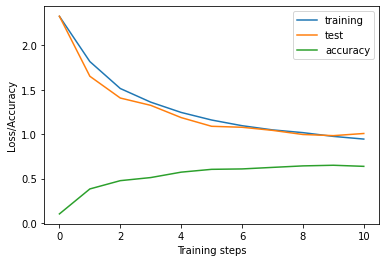

In [ ]:
# Visualisation
import matplotlib.pyplot as plt

plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2,line3),("training","test", "accuracy"))
plt.show()